In [1]:
%load_ext autoreload
%autoreload 2

Number of samples: 3831


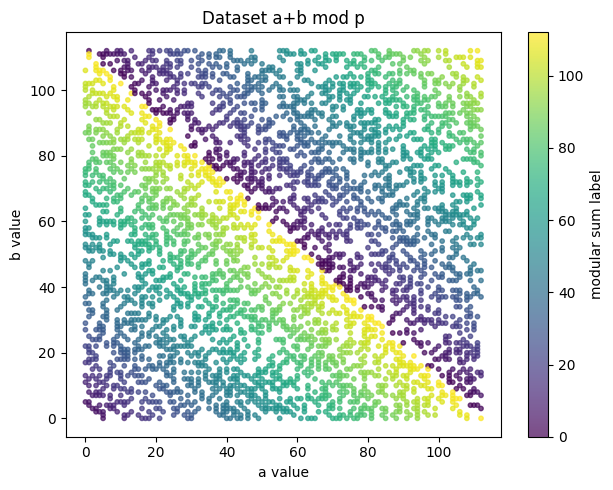

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from utils.config import MODELS_DIR
import os
from tasks.arithmetic.dataset import get_mod_arithmetic_cp_dataloaders, ArithmeticDatasetConfig
from tasks.arithmetic import visualize_data
from models.transformer import Transformer

device = t.device("cpu")

config = ArithmeticDatasetConfig(
  p=113,
  noise_frac=0
)

train_dataloader, val_dataloader, _ = get_mod_arithmetic_cp_dataloaders(data_config=config, batch_size=256, val_frac=0.7)
visualize_data(train_dataloader)
data_iter = iter(train_dataloader)

In [20]:
from tasks.arithmetic.utils import load_model_and_dataset

checkpoint_dir = os.path.join(MODELS_DIR, 'arithmetic_transformer_baseline')

cp = load_model_and_dataset(Transformer, checkpoint_dir, checkpoint=None, device=device)

cp.val_loss

In [23]:
x, y, _ = next(iter(cp.dataloader))
t.argmax(cp.model(x), dim=-1) - y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,